# Preamble

In [1]:
using ForwardDiff, Plots, LaTeXStrings, DifferentialEquations, Roots, QuadGK, Interpolations
default(framestyle=:box, guidefont=font(14), titlefont=font(14), tickfont=font(12), legend_font=font(12), legend=false, linewidth=3);

In [2]:
Mpl = 2.435e18; # reduced Planck mass in GeV
c = 299792458; # speed of light in m/s
KinGeV = (1.160e4)^-1 * 10^-9; # Kelvin in GeV
Mpcinm = 3.086e16 * 10^6; # Mpc in m
GeVinminv = 10^9/(1.973e-7); # GeV in m^-1
GeVinMpcinv = GeVinminv * Mpcinm; # GeV in Mpc^-1
MpcinvinHz = c/Mpcinm; # Mpc^inv in Hz
yrins = 365.2422 * 24 * 60 * 60; # yr in s

Or0h2 = 4.2e-5; # current radiation density parameter * h^2
Hubblh = 0.674; # normalised Hubble parameter h

T0 = 2.725*KinGeV; # current temperature
grho0 = 3.383; # current grho
gs0 = 3.931; # current gs

In [3]:
Threads.nthreads()

10

# Background

## calculation

In [4]:
ai = [1, 1.11724, 3.12672e-1, -4.68049e-2, -2.65004e-2, -1.19760e-3, 1.82812e-4, 1.36436e-4, 8.55051e-5, 1.22840e-5, 3.82259e-7, -6.87035e-9];
bi = [1.43382e-2, 1.37559e-2, 2.92108e-3, -5.38533e-4, -1.62496e-4, -2.87906e-5, -3.84278e-6, 2.78776e-6, 7.40342e-7, 1.17210e-7, 3.72499e-9, -6.74107e-11];
ci = [1, 6.07869e-1, -1.54485e-1, -2.24034e-1, -2.82147e-2, 2.90620e-2, 6.86778e-3, -1.00005e-3, -1.69104e-4, 1.06301e-5, 1.69528e-6, -9.33311e-8];
di = [7.07388e1, 9.18011e1, 3.31892e1, -1.39779, -1.52558, -1.97857e-2, -1.60146e-1, 8.22615e-5, 2.02651e-2, -1.82134e-5, 7.83943e-5, 7.13518e-5];

In [5]:
Tth = 0.12; # temperature separation in GeV

In [6]:
grhohigh(T) = sum([ai[i]*log(T)^(i - 1) for i=1:12]) / sum([bi[i]*log(T)^(i - 1) for i=1:12]); # eff. DoF for energy density for T > 0.12 GeV
gshigh(T) = grhohigh(T) / (1 + sum([ci[i]*log(T)^(i - 1) for i=1:12]) / sum([di[i]*log(T)^(i - 1) for i=1:12])); # eff. DoF for entropy for T > 0.12 GeV

In [7]:
rhohigh(T) = π^2/30*grhohigh(T)*T^4; # energy density for T > 0.12 GeV
shigh(T) = 2*π^2/45*gshigh(T)*T^3; # entropy for T > 0.12 GeV
phigh(T) = T*shigh(T) - rhohigh(T); # pressure for T > 0.12 GeV

In [8]:
# some fitting functions
Sfit(x) = 1 + 7/4*exp(-1.0419*x) * (1 + 1.034*x + 0.456426*x^2 + 0.0595249*x^3);
frho(x) = exp(-1.04855*x) * (1 + 1.03757*x + 0.508630*x^2 + 0.0893988*x^3);
brho(x) = exp(-1.03149*x) * (1 + 1.03317*x + 0.398264*x^2 + 0.0648056*x^3);
fs(x) = exp(-1.04190*x) * (1 + 1.03400*x + 0.456426*x^2 + 0.0595248*x^3);
bs(x) = exp(-1.03365*x) * (1 + 1.03397*x + 0.342548*x^2 + 0.0506182*x^3);

In [9]:
# mass params. in GeV
me = 511e-6;
mmu = 0.1056;
mpi0 = 0.13;
mpipm = 0.140;
m1 = 0.5;
m2 = 0.77;
m3 = 1.2;
m4 = 2;

In [10]:
# neutrino temperature
Tnu(T) = (4/11)^(1/3) * Sfit(me/T)^(1/3) * T;

In [11]:
grhogammalow(T) = 2.030 + 3.495*frho(me/T) + 3.446*frho(mmu/T) + 1.05*brho(mpi0/T) + 2.08*brho(mpipm/T) + 4.165*brho(m1/T) + 30.55*brho(m2/T) + 89.4*brho(m3/T) + 8209*brho(m4/T); # eff. DoF for photon energy density for T < 0.12 GeV
gsgammalow(T) = 2.008 + 3.442*fs(me/T) + 3.468*fs(mmu/T) + 1.034*bs(mpi0/T) + 2.068*bs(mpipm/T) + 4.16*bs(m1/T) + 30.55*bs(m2/T) + 90*bs(m3/T) + 6209*bs(m4/T); # eff. DoF for photon entropy for T < 0.12 GeV
grhonulow(T) = 1.353*Sfit(me/T)^(4/3); # eff. DoF for neutrino energy density for T < 0.12 GeV
gsnulow(T) = 1.923*Sfit(me/T); # eff. DoF for neutrino entropy for T < 0.12 GeV

In [12]:
# T < 0.12 GeV
rhogammalow(T) = π^2/30*grhogammalow(T)*T^4; # photon energy density
sgammalow(T) = 2*π^2/45*gsgammalow(T)*T^3; # photon entropy
rhonulow(T) = π^2/30*grhonulow(T)*T^4; # neutrino energy density
snulow(T) = 2*π^2/45*gsnulow(T)*T^3; # neutrino entropy
pgammalow(T) = T*sgammalow(T) - rhogammalow(T); # photon pressure
pnulow(T) = Tnu(T)*snulow(T) - rhonulow(T); # neutrino pressure
rholow(T) = rhogammalow(T) + rhonulow(T); # total energy density
plow(T) = pgammalow(T) + pnulow(T); # total pressure

In [14]:
function grho(T) # eff. DoF for energy density
    if T >= Tth
        return grhohigh(T)
    else
        return grhogammalow(T) + grhonulow(T)
    end
end;

function grhop(T) # T-derivative of grho
    if T >= Tth
        return ForwardDiff.derivative(grhohigh,T)
    else
        return (ForwardDiff.derivative(grhogammalow,T) + 
            ForwardDiff.derivative(grhonulow,T))
    end
end;

function gs(T) # eff. DoF for entropy
    if T >= Tth
        return gshigh(T)
    else
        return gsgammalow(T) + gsnulow(T)
    end
end;

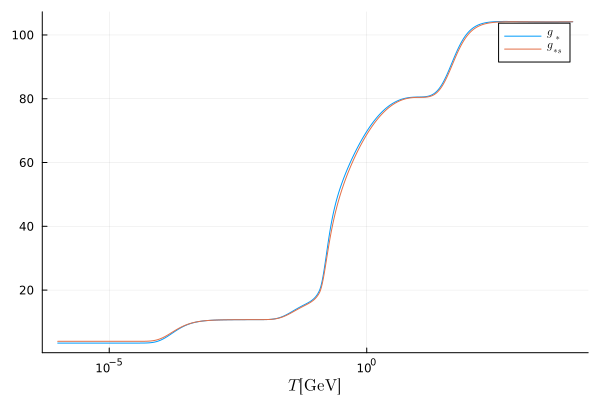

In [15]:
Tlist = [10^i for i=-6:0.01:4]
plot(grho, Tlist, xscale=:log10, label=L"$g_*$", xlabel=L"$T\,[\mathrm{GeV}]$")
plot!(gs, Tlist, label=L"$g_{*s}$")

In [16]:
function rho(T) # energy density
    if T >= Tth
        return rhohigh(T)
    else 
        return rholow(T)
    end
end;

function press(T) # pressure
    if T >= Tth
        return phigh(T)
    else
        return plow(T)
    end
end;

In [17]:
EoSw(T) = press(T)/rho(T); # equation-of-state param. w

function cs2(T) # sound speed squared
    if T >= Tth
        return ForwardDiff.derivative(phigh,T)/ForwardDiff.derivative(rhohigh,T)
    else
        return ForwardDiff.derivative(plow,T)/ForwardDiff.derivative(rholow,T)
    end
end;

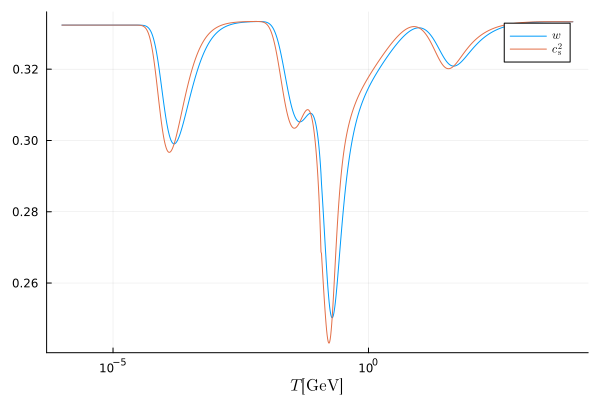

In [18]:
plot(EoSw, Tlist, xscale=:log10, label=L"$w$", xlabel=L"$T\,[\mathrm{GeV}]$")
plot!(cs2, Tlist, label=L"$c_\mathrm{s}^2$")

In [19]:
T0 = 2.725*KinGeV; # current temperature
grho0 = grho(T0); # current grho
gs0 = gs(T0); # current gs

In [20]:
calH(T, scalea) = scalea * sqrt(rho(T)/3/Mpl^2) * GeVinMpcinv; # conformal Hubble in Mpc^-1

In [21]:
Ti = 1e6; # initial temperature
scaleai = (gs0/gs(Ti))^(1/3)*T0/Ti; # temporal initial scale factor 
etai = 1/calH(Ti, scaleai); # initial conformal time

etaf = 10; # final conformal time

In [22]:
etai

5.842207902333349e-14

In [23]:
function bgEoM(du,u,p,lneta) # u[1] = T, u[2] = scalea
    du[1] = -3*exp(lneta)*(1 + EoSw(u[1])) * calH(u[1], u[2]) * grho(u[1]) / (grhop(u[1]) + 4*grho(u[1])/u[1])
    du[2] = exp(lneta)*u[2]*calH(u[1],u[2])
end;

ui = [Ti,scaleai];
lnetaspan = (log(etai),log(etaf));
bgprob = ODEProblem(bgEoM,ui,lnetaspan);
@time bgsol = solve(bgprob,Tsit5(),reltol=1e-10,abstol=1e-10);

  0.622618 seconds (5.55 M allocations: 157.586 MiB, 3.18% gc time, 69.28% compilation time)


In [24]:
Tsol(eta) = bgsol(log(eta))[1];
asol(eta) = bgsol(log(eta))[2];

In [28]:
norm = Tsol(etaf)/T0*asol(etaf); # renormalisation factor so that a0 = 1
anorm(eta) = asol(eta/norm)/norm; # renormalised scale factor
Tnorm(eta) = Tsol(eta/norm); # T with the renormalised eta
calHnorm(eta) = calH(Tnorm(eta), anorm(eta)); # calH with the renormalised eta
rhoQnorm(eta) = rho(Tnorm(eta))^(1/4);
#af = anorm(norm*etaf); # renormalised scale factor at the final time
#calHf = calHnorm(norm*etaf); # calH at the final time

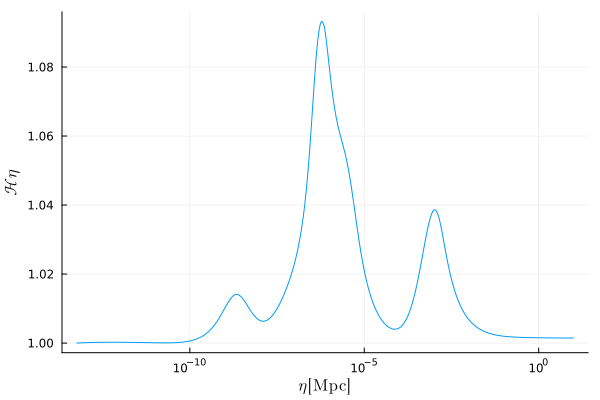

In [29]:
etalist = [10^i for i=log10(norm*etai):0.01:log10(norm*etaf)];
plot(etalist, map(x -> x*calHnorm(x), etalist), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}\eta$", legend=false)

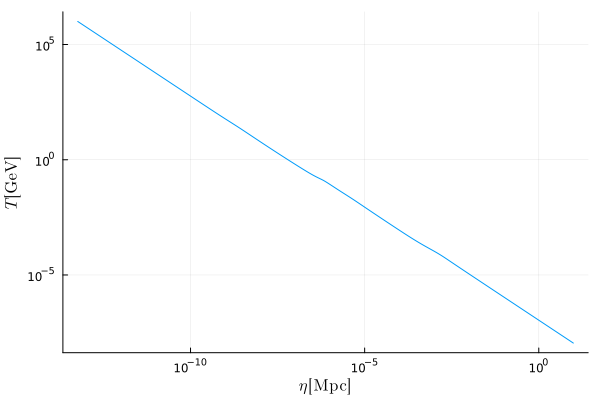

In [30]:
plot(Tnorm, etalist, xscale=:log10, yscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$T\,[\mathrm{GeV}]$", legend=false)

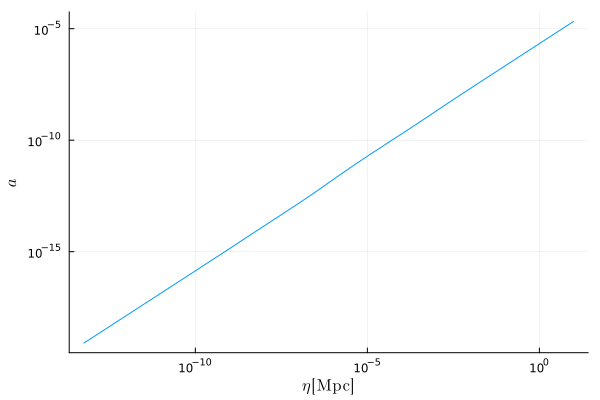

In [31]:
plot(anorm, etalist, xscale=:log10, yscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$a$", legend=false)

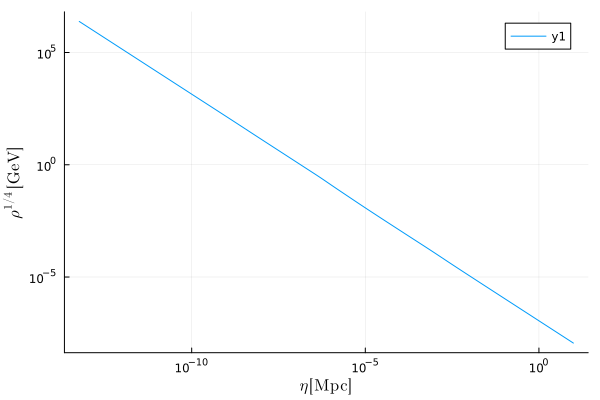

In [32]:
plot(rhoQnorm, etalist, xscale=:log10, yscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\rho^{1/4}\,[\mathrm{GeV}]$")

In [33]:
EoSwsol(eta) = EoSw(Tnorm(eta));
cs2sol(eta) = cs2(Tnorm(eta));
grhosol(eta) = grho(Tnorm(eta));
gssol(eta) = gs(Tnorm(eta));

In [34]:
rhoQis1e4(eta) = rhoQnorm(eta) - 1e4;
eta1e4 = find_zero(rhoQis1e4, (etai*norm,1e-9))

1.3990721574405065e-11

In [35]:
(rhoQnorm(eta1e4), EoSwsol(eta1e4), cs2sol(eta1e4))

(10000.000000000013, 0.33331897239417807, 0.33332907441085496)

In [36]:
anorm(eta1e4)

1.927432210988474e-17

In [37]:
frkH(eta) = calHnorm(eta)*(1+cs2sol(eta));

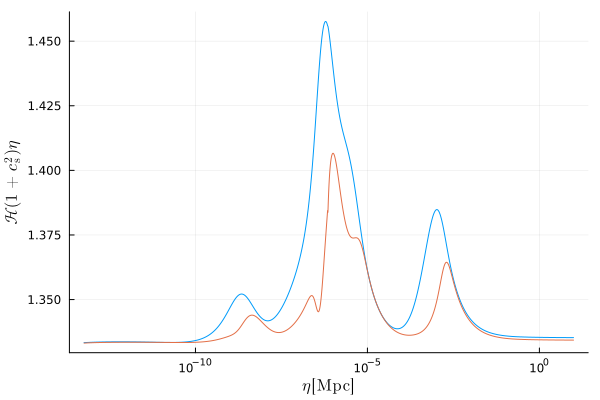

In [38]:
plot(etalist, map(x -> x*calHnorm(x)*(1+1/3), etalist), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}(1+c_\mathrm{s}^2)\eta$", legend=false)
plot!(etalist, map(x -> x*frkH(x), etalist))

In [45]:
frka(eta) = anorm(eta)^(4/3)*quadgk(frkH,etai*norm,eta)[1];

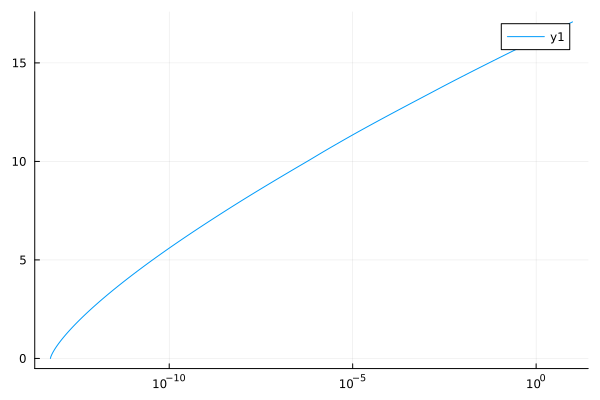

In [46]:
plot(etalist, map(x -> frka(x)^(3/4)/anorm(x), etalist), xscale=:log10)

In [47]:
lnetaspan = log10(norm*etai):0.01:log10(norm*etaf)

lnetaList = [lneta for lneta in lnetaspan];
anormList = [anorm(10^lneta) for lneta in lnetaspan];
calHList = [calHnorm(10^lneta) for lneta in lnetaspan];
EoSwList = [EoSwsol(10^lneta) for lneta in lnetaspan];
cs2List = [cs2sol(10^lneta) for lneta in lnetaspan];
grhoList = [grhosol(10^lneta) for lneta in lnetaspan];
gsList = [gssol(10^lneta) for lneta in lnetaspan];
frkHList = [frkH(10^lneta) for lneta in lnetaspan];
frkaList = [frka(10^lneta) for lneta in lnetaspan];

In [48]:
open("data/bg.dat","w") do out
    Base.print_array(out, hcat(lnetaList[:],anormList[:],calHList[:],EoSwList[:],cs2List[:],grhoList[:],gsList[:],frkHList[:],frkaList[:]))
end

## load

In [4]:
f = open("data/bg.dat","r");
body = readlines(f);
close(f)

strarray = [split(body[i],r"\s+",keepempty=false) for i=1:length(body)];
numarray = [parse.(Float64, strarray[i]) for i=1:length(strarray)];

lnetaList = [numarray[i][1] for i=1:length(numarray)];
anormList = [numarray[i][2] for i=1:length(numarray)];
calHList = [numarray[i][3] for i=1:length(numarray)];
EoSwList = [numarray[i][4] for i=1:length(numarray)];
cs2List = [numarray[i][5] for i=1:length(numarray)];
grhoList = [numarray[i][6] for i=1:length(numarray)];
gsList = [numarray[i][7] for i=1:length(numarray)];
frkHList = [numarray[i][8] for i=1:length(numarray)];
frkaList = [numarray[i][9] for i=1:length(numarray)];

In [5]:
lnetaspan = range(lnetaList[1], lnetaList[length(lnetaList)], length=length(lnetaList))
etai = 10^lnetaList[1];
etaf = 10^lnetaList[length(lnetaList)];

aCSI = CubicSplineInterpolation(lnetaspan, anormList);
aint(eta) = aCSI(log10(eta));

calHCSI = CubicSplineInterpolation(lnetaspan, calHList);
calHint(eta) = calHCSI(log10(eta));

EoSwCSI = CubicSplineInterpolation(lnetaspan, EoSwList);
EoSwint(eta) = EoSwCSI(log10(eta));

cs2CSI = CubicSplineInterpolation(lnetaspan, cs2List);
cs2int(eta) = cs2CSI(log10(eta));

grhoCSI = CubicSplineInterpolation(lnetaspan, grhoList);
grhoint(eta) = grhoCSI(log10(eta));

gsCSI = CubicSplineInterpolation(lnetaspan, gsList);
gsint(eta) = gsCSI(log10(eta));

frkHCSI = CubicSplineInterpolation(lnetaspan, frkHList);
frkHint(eta) = frkHCSI(log10(eta));

frkaCSI = CubicSplineInterpolation(lnetaspan, frkaList);
frkaint(eta) = frkaCSI(log10(eta));

In [6]:
(etai, etaf)

(5.780118553023619e-14, 9.816049643148732)

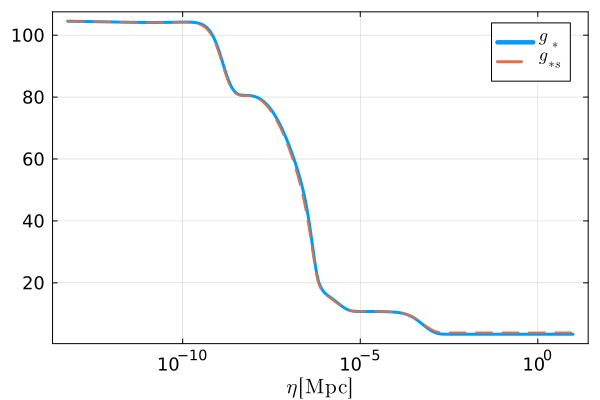

In [7]:
etaList = [10^lnetaList[i] for i=1:length(lnetaList)];
plot(grhoint, etaList, xscale=:log10, label=L"$g_*$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", legend=true)
plot!(gsint, etaList, label=L"$g_{*s}$", linestyle=:dash, linewidth=:2)

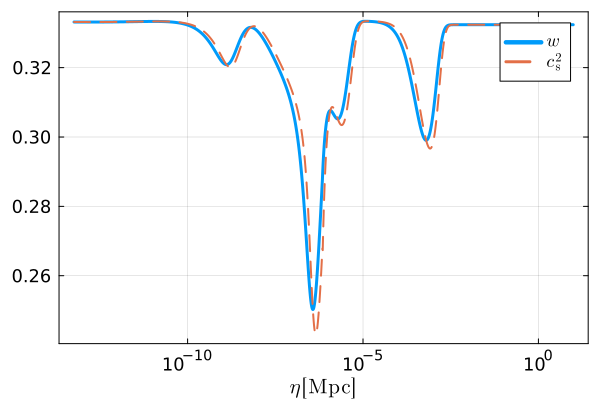

In [8]:
plot(EoSwint, etaList, xscale=:log10, label=L"$w$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", legend=true)
plot!(cs2int, etaList, label=L"$c_\mathrm{s}^2$", linestyle=:dash, linewidth=:2)

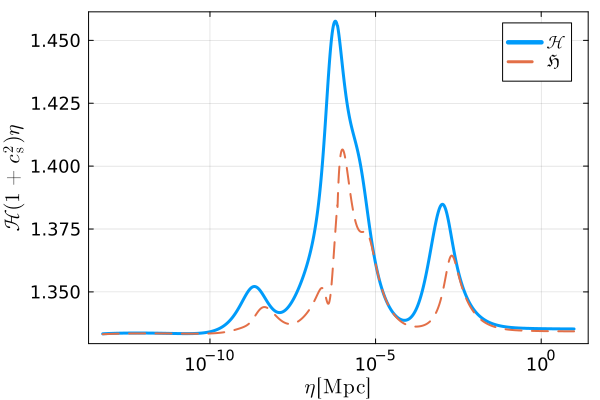

In [9]:
plot(etaList, map(x -> x*calHint(x)*(1+1/3), etaList), xscale=:log10, label=L"$\mathcal{H}$", xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathcal{H}(1+c_\mathrm{s}^2)\eta$", legend=true)
plot!(etaList, map(x -> x*frkHint(x), etaList), label=L"$\mathfrak{H}$", linestyle=:dash, linewidth=:2)

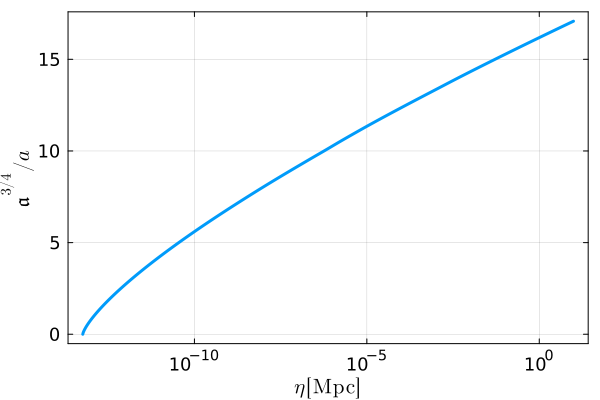

In [10]:
plot(etaList, map(x -> frkaint(x)^(3/4)/aint(x), etaList), xscale=:log10, xlabel=L"$\eta\,[\mathrm{Mpc}]$", ylabel=L"$\mathfrak{a}^{3/4}/a$", legend=false)

# Scalar

## test

In [41]:
k = 1e6;
xi = 1e-3;
xf = 1e+3;

omegask2(x) = cs2int(x/k) + 3*calHint(x/k)^2/k^2*(cs2int(x/k)-EoSwint(x/k));
omegaskp(x) = sqrt(max(omegask2(x),0));
omegaskpp(x) = ForwardDiff.derivative(omegaskp,x);
omegaskppp(x) = ForwardDiff.derivative(omegaskpp,x);
omegask2m(x) = omegask2(x) - omegaskp(x)^2;

In [42]:
function scalarEoM(du,u,p,x) # u[1] = A, u[2] = A', u[3] = theta, u[4] = theta'
    wp = omegaskp(x);
    wpp = omegaskpp(x);
    wppp = omegaskppp(x);
    wm2 = omegask2m(x);
    frkH = frkHint(x/k);
    
    du[1] = u[2];
    du[2] = -3*frkH/k*u[2] - (wm2 + (wpp*x+u[4])*(2*wp+wpp*x+u[4]) )*u[1];
    
    du[3] = u[4];
    du[4] = ( (3*frkH/k+2*u[2]/u[1])*u[4] + 2*wpp + wppp*x + 3*frkH/k*(wp+wpp*x) + 
        2*(wp+wpp*x)*u[2]/u[1] );
end;

ui = [1,0,0,0];
xspan = (xi, xf);
scalarprob = ODEProblem(scalarEoM,ui,xspan,0);

In [43]:
@time scalarsol = solve(scalarprob,Tsit5(),reltol=1e-10,abstol=1e-10);

 39.435667 seconds (1.06 G allocations: 22.346 GiB, 4.39% gc time, 0.13% compilation time: 100% of which was recompilation)


┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/OK4PC/src/integrator_interface.jl:585


# Tensor

## test

In [44]:
k = 1e6;
xi = 1e-3;
xf = 1e+3;

omegatk2(x) = 1 - (1-3*EoSwint(x/k))/2*calHint(x/k)^2/k^2;
omegatkp(x) = sqrt(max(omegatk2(x),0));
omegatkpp(x) = ForwardDiff.derivative(omegatkp,x);
omegatkppp(x) = ForwardDiff.derivative(omegatkpp,x);
omegatk2m(x) = omegatk2(x) - omegatkp(x)^2;

In [53]:
function tensorEoM(du,u,p,x) # u[1] = A, u[2] = A', u[3] = theta, u[4] = theta'
    wp = omegatkp(x);
    wpp = omegatkpp(x);
    wppp = omegatkppp(x);
    wm2 = omegatk2m(x);    
    du[1] = u[2];
    du[2] = - (wm2 + (wpp*x+u[4])*(2*wp+wpp*x+u[4]) )*u[1];
    
    du[3] = u[4];
    du[4] = 2*u[2]/u[1]*u[4] + 2*wpp + wppp*x + 2*(wp+wpp*x)*u[2]/u[1];
end;

ui = [1,0,0,0];
xspan = (xi, xf);
tensorprob = ODEProblem(tensorEoM,ui,xspan,0);

In [58]:
omegatk2m(xi)

-18120.581827750437

In [57]:
dus = [0.,0.,0.,0.];
tensorEoM(dus,ui,0,xi);
dus

4-element Vector{Float64}:
   0.0
 NaN
   0.0
 NaN

In [46]:
@time tensorsol = solve(tensorprob,Tsit5(),reltol=1e-10,abstol=1e-10);

LoadError: BoundsError: attempt to access 1424-element extrapolate(scale(interpolate(OffsetArray(::Vector{Float64}, 0:1425), BSpline(Cubic(Line(OnGrid())))), (-13.23806325389851:0.01:0.9919367461014907,)), Throw()) with element type Float64 at index [NaN]